# Importing Libraies

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Flatten ,Dense ,Dropout ,BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Dataset 

### Specifying Image Size

In [2]:
image_size = (128, 128)
image_shape = (128, 128, 3)

## Loading with Resize

In [3]:
with_mask_folder = '/kaggle/input/face-mask-dataset/data/with_mask'
without_mask_folder = '/kaggle/input/face-mask-dataset/data/without_mask'

def load_resize_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, image_size) 
            images.append(img)
    return images

with_mask_images = load_resize_images(with_mask_folder)
without_mask_images = load_resize_images(without_mask_folder)

## Creating Labels

* #### 1: With Mask
* #### 0: Without Mask

In [4]:
with_mask_labels = np.ones(len(with_mask_images))  
without_mask_labels = np.zeros(len(without_mask_images))

# Concatenate the images and labels
X = np.array(with_mask_images + without_mask_images)
Y = np.concatenate((with_mask_labels, without_mask_labels), axis=0)

## Spliting Training And Testing Data

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
# Print shapes for confirmation
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (6042, 128, 128, 3)
Y_train shape: (6042,)
X_test shape: (1511, 128, 128, 3)
Y_test shape: (1511,)


# Scaling Images

In [6]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

#  Creating Custom CNN Model

In [14]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape,
                 kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(128, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

model.add(SeparableConv2D(256, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

# Additional Block
model.add(SeparableConv2D(512, (3, 3), activation='relu',
                          depthwise_regularizer=regularizers.l2(0.001),
                          pointwise_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D((2, 2)))

# Flatten instead of GAP
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.35))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1,
    restore_best_weights=True, 
    min_delta=0.01
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3,
    min_lr=1e-6, 
    verbose=1
)

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 28, 28, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 12, 12, 256)         │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 4, 4, 512)           │         133,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │              

 Total params: 2,297,544 (8.76 MB)

 Trainable params: 764,930 (2.92 MB)

 Non-trainable params: 2,752 (10.75 KB)

 Optimizer params: 1,529,862 (5.84 MB)

In [15]:
# Split data into training and validation sets
X_train_aug, X_val, Y_train_aug, Y_val = train_test_split(
   X_train_scaled, Y_train, test_size=0.1, random_state=42
)

# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare augmented training data
train_generator = datagen.flow(X_train_aug, Y_train_aug, batch_size=32)

# Training The Model

In [16]:
# Train the model with augmented data and validation set
history = model.fit(
    train_generator,
    validation_data=(X_val, Y_val),  # Use the separated validation set
    epochs=100,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.7377 - loss: 1.9023 - val_accuracy: 0.5339 - val_loss: 2.1905 - learning_rate: 0.0010
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.8655 - loss: 1.5479 - val_accuracy: 0.5339 - val_loss: 1.9105 - learning_rate: 0.0010
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.8984 - loss: 1.3100 - val_accuracy: 0.9124 - val_loss: 1.1936 - learning_rate: 0.0010
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9152 - loss: 1.1310 - val_accuracy: 0.9372 - val_loss: 0.9536 - learning_rate: 0.0010
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9229 - loss: 0.9648 - val_accuracy: 0.9521 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.9168 - loss: 0.8652 - val_accuracy: 0.9421 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accura

# Evaluating the model

In [17]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9838 - loss: 0.1633
Test Accuracy: 98.61%


### Displaying Result
 #### Classification Report

In [23]:
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(Y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       768
         1.0       0.99      0.98      0.99       743

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



#### Loss and Accuracy for Training & Validation

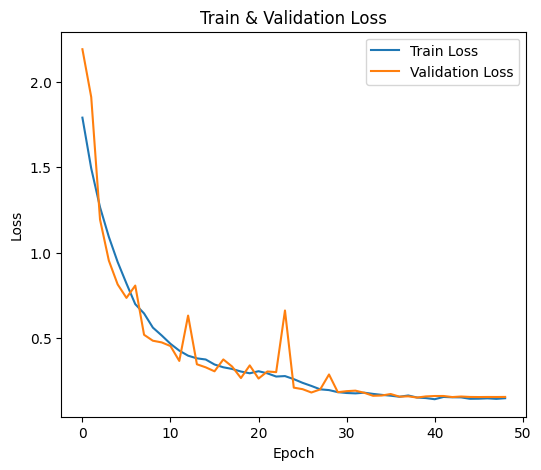

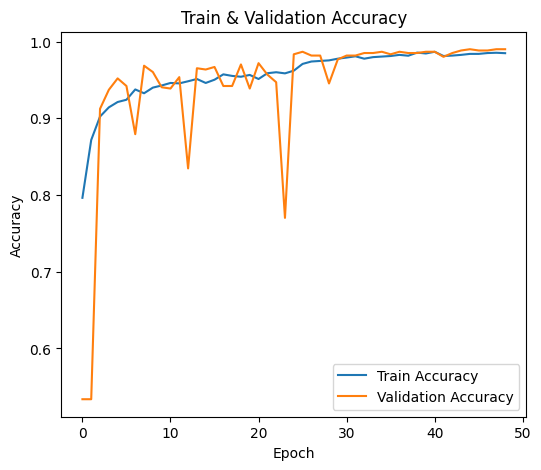

In [21]:
h = history

plt.figure(figsize=(6, 5)) 
plt.plot(h.history['loss'], label='Train Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Train & Validation Loss')  
plt.xlabel('Epoch') 
plt.ylabel('Loss')  
plt.legend()
plt.show()

plt.figure(figsize=(6, 5)) 
plt.plot(h.history['accuracy'], label='Train Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train & Validation Accuracy')  
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Confusion Matrix

Confusion Matrix:
[[753  15]
 [ 19 724]]


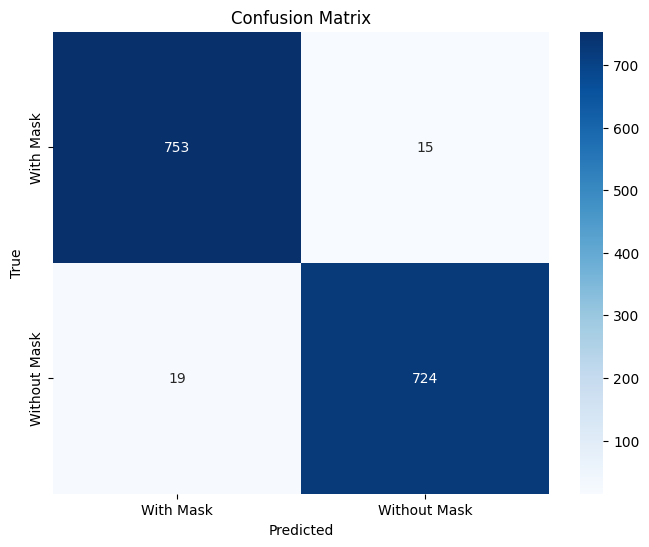

In [20]:
class_names = ['With Mask', 'Without Mask']

conf_matrix = confusion_matrix(Y_test, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Save the model to HDF5 file format
model.save('face_mask_cnn_model.keras')